In [1]:
import pandas as pd
import numpy as np
import ExMAS
import ExMAS.main
import ExMAS.utils
import pprint
import itertools
import csv
import os
import osmnx as ox
import dotmap
import sys
import random
import datetime
import requests
import time
import math
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [16, 16]
import networkx as nx #graphs
cwd = os.getcwd()

import seaborn as sns
import matplotlib.pyplot as plt

local imports

In [2]:
from ExMAS.utils import inData as inData
from dotmap import DotMap
from main import make_query, parse_OTP_response
from utils import plot
from utils import get_config
from datetime import timedelta
from scipy import optimize

## ExMAS (OH) for ALL PT users

In [37]:
df = pd.read_csv('georequests_O(area10)_D.csv') # for each area
df = df.filter(['origin_x','origin_y','destination_x', 'destination_y', 'treq'], axis = 1)
df['treq'] = pd.to_datetime(df.treq)
params = ExMAS.utils.get_config('default_SUM.json') # load the default
params.city = 'Krakow, Poland'
params = ExMAS.utils.make_paths(params) # update file paths
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph
df

,origin_x,origin_y,destination_x,destination_y,treq
0,19.865141,50.021139,19.906643,50.030131,2024-03-28 08:01:44
1,19.864924,50.020894,19.927274,50.057716,2024-03-28 07:53:28
2,19.875981,50.018058,19.880110,50.014884,2024-03-28 08:08:08
3,19.886061,50.016556,19.947150,50.069255,2024-03-28 08:01:00
4,19.865979,50.019758,20.002212,50.105225,2024-03-28 07:59:49
...,...,...,...,...,...
161,19.877727,50.020803,19.880110,50.014884,2024-03-28 07:47:40
162,19.867177,50.015471,19.924829,50.049414,2024-03-28 08:08:09
163,19.871075,50.010122,19.923459,50.056796,2024-03-28 07:53:32
164,19.883681,50.018113,19.977727,50.062286,2024-03-28 07:56:51


In [4]:
def run_ExMAS_SUM(inData, params, hub, frac, repl):

    params.nP = int(frac * len(df))
    sample = df.sample(n = int(frac * len(df)), replace=False, weights=None, random_state=None, axis=None) # demand of RP=frac*population
    sample['origin'] = sample.apply(lambda row:  ox.get_nearest_node(inData.G, (row['origin_y'], row['origin_x'])), axis = 1)
    # sample['destination'] = sample.apply(lambda row:  ox.get_nearest_node(inData.G, (row['desti_y'], row['desti_x'])), axis = 1) # in case of O-D by PT
    if type(sample['treq'][0]) == str:
        sample['treq'] = sample['treq'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    # inData = ExMAS.utils.generate_demand(inData, params) #generate trip requests 
    inData.requests = sample
    
    
    my_requests = inData.requests
    my_requests['destination'] = hub[1] 
    my_requests["origin"] = sample.origin.values
    my_requests['dist'] = my_requests.apply(lambda request: inData.skim.loc[request.origin, request.destination], axis=1)
    my_requests['ttrav'] = my_requests.apply(lambda request: pd.Timedelta(request.dist, 's').floor('s'), axis=1) 
    my_requests.tarr = [request.treq + request.ttrav for _, request in my_requests.iterrows()]
    my_requests['pax_id'] = list(range(len(my_requests)))
    
       
    inData.requests = my_requests
    # inData.requests.to_csv(f'res/10/ttrav_{hub[0]}_{frac}_{repl}.csv')
    inData = ExMAS.main(inData, params)
    schedule = inData.ExMAS.schedule
    requests = inData.ExMAS.requests
   
    KPIs = inData.sblts.res.to_frame()[:23]
    # KPIs['description']  = ExMAS.utils.KPIs_descriptions
    KPIs.columns = ['KPI']
    KPIs
    # KPIs.to_csv(f'res/10/KPI_{hub[0]}_{frac}_{repl}.csv') #res/     
   
    return KPIs, schedule, requests

params.shared_discount = 0.2
params.simTime = 0.5
params.t0 = params.t0.replace(hour=8)
params.speeds.ride = 6
params.VoT = 0.0035
params.pax_delay = 15
params.max_degree = 8 
params.price = 1.5
results = dict()
 
#    hubs   
hubs = [('hub1', ox.get_nearest_node(inData.G,[50.01844,19.88948]))]#

for frac in  [1]: #list of frac 0.001, 0.0015, 0.002, 0.003, 0.005, 0.007, 0.008, 0.009, 0.01
    for h in hubs:
        for i in range(1): 
            print(h[0], frac, i + 1)
            results[frac] = run_ExMAS_SUM(inData, params, h, frac, i)

hub1 1 1
10-05-24 19:41:23-INFO-Initializing pairwise trip shareability between 166 and 166 trips.
10-05-24 19:41:23-INFO-creating combinations
10-05-24 19:41:23-INFO-27390	 nR*(nR-1)
10-05-24 19:41:23-INFO-Reduction of feasible pairs by 99.43%
10-05-24 19:41:23-INFO-Degree 2 	Completed
10-05-24 19:41:23-INFO-trips to extend at degree 2 : 354
10-05-24 19:41:23-INFO-At degree 2 feasible extensions found out of 29 searched
10-05-24 19:41:23-INFO-Degree 3 	Completed
10-05-24 19:41:23-INFO-trips to extend at degree 3 : 29
10-05-24 19:41:23-INFO-At degree 3 feasible extensions found out of 4 searched
10-05-24 19:41:23-INFO-Degree 4 	Completed
10-05-24 19:41:23-INFO-trips to extend at degree 4 : 4
10-05-24 19:41:23-INFO-At degree 4 feasible extensions found out of 0 searched
10-05-24 19:41:23-INFO-Degree 5 	Completed
10-05-24 19:41:23-INFO-No more trips to exted at degree 5
10-05-24 19:41:24-INFO-Matching 166 trips to 553 rides in order to minimize u_veh
10-05-24 19:41:24-INFO-Problem soluti

In [5]:
inData.sblts.rides.sample(1)

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,lambda_r,PassHourTrav_ns,row,selected
511,"[141, 154]",4.9425,330,21,"[3.6769750000000005, 1.2655250000000002]","[1463.5, 208, 107, 0]","[141, 154]","[154, 141]",2.0,511,0.191176,408.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [6]:
inData.sblts.requests.sample(1)

,index,origin_x,origin_y,destination_x,destination_y,treq,origin,destination,dist,ttrav,pax_id,VoT,delta,u,u_PT,ride_id,ttrav_sh,u_sh,kind,position
52,137,19.880713,50.018103,19.892438,50.031394,583,497390973,1989392511,959,159,47,0.0035,26.538462,1.995,999999,52,159.0,1.995,1,0


In [7]:
inData.sblts.schedule.sample(1)

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,lambda_r,PassHourTrav_ns,row,selected
215,"[140, 141]",7.58135,360,20,"[3.9430500000000004, 3.6383000000000005]","[1440.0, 44, 301, 0]","[140, 141]","[140, 141]",2,215,0.42492,626.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1


In [8]:
inData.sblts.rides.head(1)

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,lambda_r,PassHourTrav_ns,row,selected
0,[0],2.3375,187,1,[2.3375],"[0.0, 187.0]",[0],[0],1.0,0,0.2,187.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1


In [9]:
df_SUM = df
df_SUM['hub'] = inData.sblts.requests.destination
df_SUM['ttrav'] = inData.sblts.requests.ttrav
df_SUM['tarr'] = pd.to_datetime(inData.requests.treq) + df_SUM.apply(lambda df_SUM: pd.Timedelta(df_SUM.ttrav, 's').floor('s'), axis=1)
df_SUM['u'] = inData.sblts.requests.u
df_SUM['ttrav_sh'] = inData.sblts.requests.ttrav_sh
df_SUM['tarr_sh'] = pd.to_datetime(inData.requests.treq) + df_SUM.apply(lambda df_SUM: pd.Timedelta(df_SUM.ttrav_sh, 's').floor('s'), axis=1)
df_SUM['u_sh'] = inData.sblts.requests.u_sh
# df_ABS.to_csv(f'res/ExMASrequests_OH_area10.csv')

## OTP (HD) for ALL PT users

In [10]:
PATH = 'georequests_O(area10)_D.csv'
OTP_API = "http://localhost:8080/otp/routers/default/plan"

params = get_config('default_SUM.json')

In [11]:
params.transfertime = 30 # transfertime for hub NSM-PT

df1 = df_SUM.rename(columns = {'treq': 'treq_origin'})
df1['origin_x'] = 19.88948 # hub coord_x
df1['origin_y'] = 50.01844 # hub coord_y
df1['treq'] = pd.to_datetime(df_SUM.tarr_sh) + timedelta(seconds=params.transfertime) # treq for PT

In [12]:
df2 = df1.apply(lambda row: 
                 parse_OTP_response(requests.get(OTP_API, params=make_query(row.squeeze())).json()), axis=1)

In [13]:
for name in list(df2[0].keys()):
    vals = []
    for i in range(len(df2)):
        if df2[i]['success'] == True:
            vals.append(df2[i][name])
        else:
            vals.append(None)
    df1[name] = vals
# df1[:3]

In [14]:
def PT_utility(requests, params):
    if 'walkDistance' in requests.columns:
        
        # params.ticket_price = 0.7
        
        requests = requests
        requests['PT_fare'] = 1 + requests.transitTime * params.avg_speed/1000 * params.ticket_price
        requests['u_PT'] = requests['PT_fare'] + \
                           params.VoT * (params.walk_factor * requests.walkDistance / params.speeds.walk +
                                           params.wait_factor * requests.waitingTime +
                                           params.transfer_penalty * requests.transfers + requests.transitTime)
    return requests

In [15]:
reqs = PT_utility(df1, params)

## UTILITIES OD for ALL PT users

In [16]:
df_PT_OD = pd.read_csv('PT_utility_OD(area10).csv')
df_PrT_OD = pd.read_csv('Pr_utility_OD(area10).csv')

df_SUM['u_PT_HD'] = reqs.u_PT                                  #utilities of PT (HUB-destinations)
df_SUM['u_PT_OD'] = df_PT_OD.u_PT                              #utilities of PT (origin-destinations)
df_SUM["u_PrT"] = df_PrT_OD.u.values                           #utilities of Pr (origin-destinations)
df_SUM['N'] = np.arange(df_SUM.shape[0])
df_SUM.sample(3)

,origin_x,origin_y,destination_x,destination_y,treq,hub,ttrav,tarr,u,ttrav_sh,tarr_sh,u_sh,u_PT_HD,u_PT_OD,u_PrT,N
16,19.885603,50.015955,19.896750,50.092024,2024-03-28 07:46:28,1989392511,316,2024-03-28 07:51:44,3.9530,316.0,2024-03-28 07:51:44,3.915600,21.244866,18.643110,24.3905,16
22,19.882427,50.018439,19.952747,50.017222,2024-03-28 08:06:43,1989392511,250,2024-03-28 08:10:53,3.1295,250.0,2024-03-28 08:10:53,3.043475,10.451289,19.397054,6.7780,22
162,19.867177,50.015471,19.924829,50.049414,2024-03-28 08:08:09,1989392511,390,2024-03-28 08:14:39,4.8780,390.0,2024-03-28 08:14:39,4.878000,7.244044,8.822348,24.1685,162


## MODE CHOICE

In [17]:
def calc_E_Psum(ASC=0):    
    df_SUM['u_SUM_OD'] = df_SUM.u_sh + reqs.u_PT + ASC
    df_SUM['p_SUM'] = df_SUM.apply(lambda df_SUM: math.exp(df_SUM.u_SUM_OD), axis=1) / \
                     (df_SUM.apply(lambda df_SUM: math.exp(df_SUM.u_SUM_OD), axis=1) +  \
                      df_SUM.apply(lambda df_SUM: math.exp(df_SUM.u_PT_OD), axis=1))
    return df_SUM.p_SUM.mean()

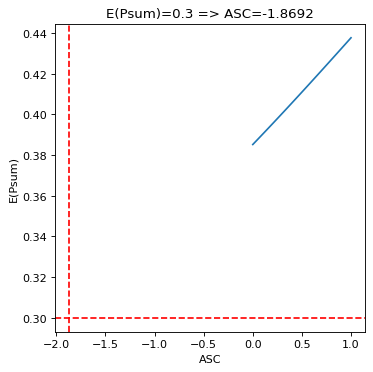

In [18]:
# Calculate ASC for the given E(Psum)
EPsum = 0.3
asc_opt = optimize.fsolve(lambda x: calc_E_Psum(x) - EPsum, 0)[0]
# Show graphics
ascs = np.linspace(0, 1, 100)
plt.figure(figsize=(5, 5), dpi=80)
plt.plot(ascs,  [calc_E_Psum(asc) for asc in ascs])
plt.title(f'E(Psum)={EPsum} => ASC={round(asc_opt, 5)}')
plt.xlabel('ASC')
plt.ylabel('E(Psum)')
plt.axhline(EPsum, color='red', linestyle='--')
plt.axvline(asc_opt, color='red', linestyle='--')
plt.show()

In [19]:
asc_opt

-1.8691996982672745

In [22]:
# Average ASC
data = {'ASC': [0.60438, -1.436947728006147, -0.6236111032861694, -1.229075878507122,
                -1.6639803576609589, -0.2555800432403951, -2.0622690008015607, 
                -1.5460605344474643, -2.200967380363101, -1.8691996982672745]}
df = pd.DataFrame(data)
ASC = df.ASC.mean()
ASC

-1.2283311724580195

In [25]:
# recalculate p_SUM
df_SUM['u_SUM_OD'] = df_SUM.u_sh + reqs.u_PT + ASC
df_SUM['p_SUM'] = df_SUM.apply(lambda df_SUM: math.exp(df_SUM.u_SUM_OD), axis=1) / \
                     (df_SUM.apply(lambda df_SUM: math.exp(df_SUM.u_SUM_OD), axis=1) +  \
                      df_SUM.apply(lambda df_SUM: math.exp(df_SUM.u_PT_OD), axis=1))
df_SUM.sample(3)

,origin_x,origin_y,destination_x,destination_y,treq,hub,ttrav,tarr,u,ttrav_sh,tarr_sh,u_sh,u_PT_HD,u_PT_OD,u_PrT,N,u_SUM_OD,p_SUM
156,19.881357,50.019998,19.886275,50.022902,2024-03-28 08:06:04,1989392511,392,2024-03-28 08:12:36,4.9015,421.0,2024-03-28 08:13:05,4.818775,6.556546,16.732034,15.2640,156,10.146989,0.001379
120,19.869218,50.011684,19.947150,50.069255,2024-03-28 07:46:58,1989392511,187,2024-03-28 07:50:05,2.3375,187.0,2024-03-28 07:50:05,2.279150,11.783645,14.668074,18.9575,120,12.834464,0.137809
158,19.879769,50.013279,19.947150,50.069255,2024-03-28 08:14:04,1989392511,325,2024-03-28 08:19:29,4.0700,360.0,2024-03-28 08:20:04,4.038600,11.783645,8.546592,16.2185,158,14.593914,0.997641


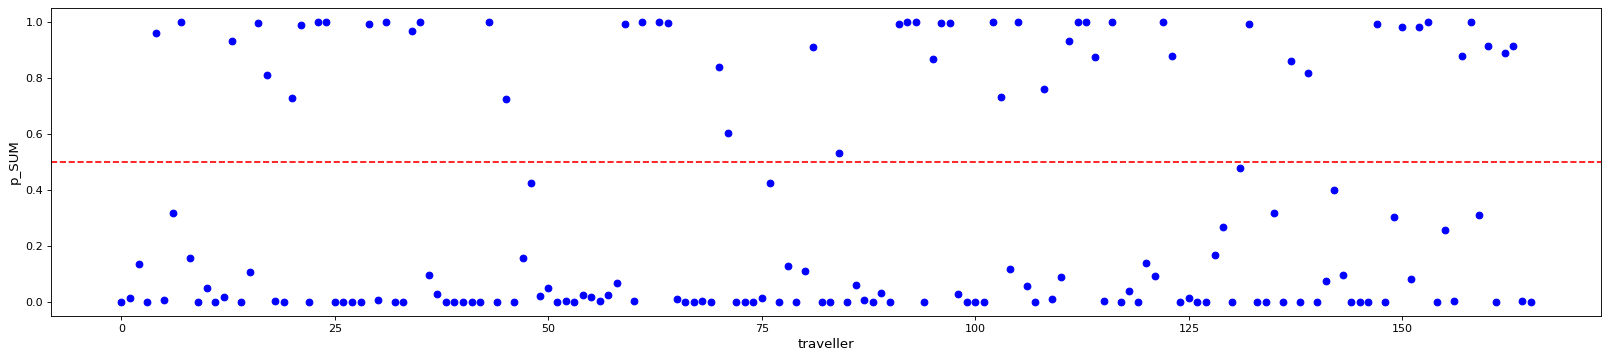

<Figure size 1600x1600 with 0 Axes>

In [30]:
plt.figure(figsize=(25, 5), dpi=80)
plt.scatter(x = df_SUM.N, y = df_SUM.p_SUM, color='blue')
plt.axhline(0.5, color='red', linestyle='--')
plt.xlabel('traveller', fontsize=12)
plt.ylabel('p_SUM', fontsize=12)
plt.show()
plt.savefig('p10.jpg')
# plt.savefig('p(10).jpg', bbox_inches='tight', dpi=100)

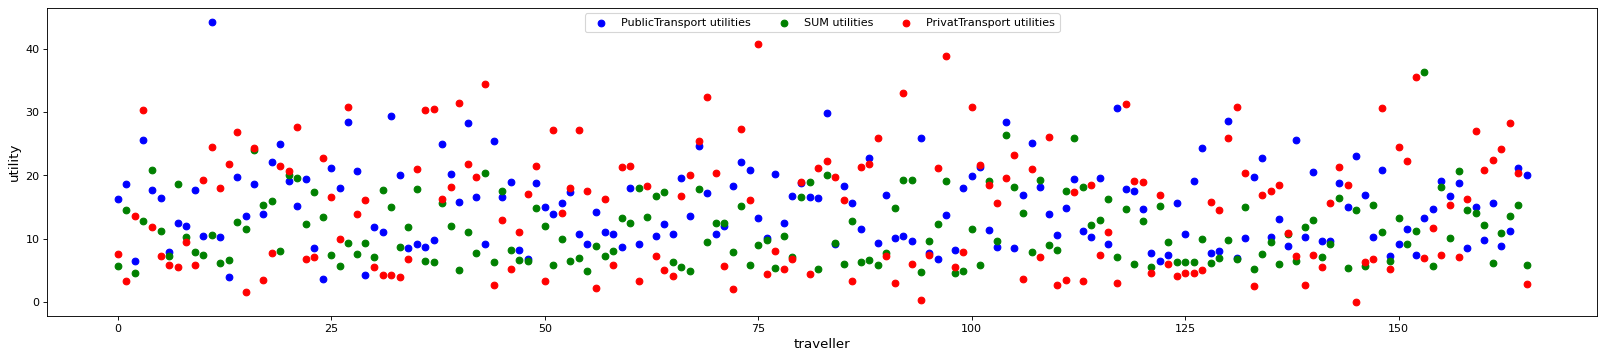

In [27]:
plt.figure(figsize=(25, 5), dpi=80)
u_PT_OD = plt.scatter(x = df_SUM.N, y = df_SUM.u_PT_OD, color='blue')
u_SUM_OD = plt.scatter(x = df_SUM.N, y = df_SUM.u_SUM_OD, color='green')
u_PrT = plt.scatter(x = df_SUM.N, y = df_SUM.u_PrT, color='red')

plt.legend((u_PT_OD, u_SUM_OD, u_PrT),
           ('PublicTransport utilities', 'SUM utilities', 'PrivatTransport utilities'),
           scatterpoints=1,
           loc='upper center',
           ncol=3,
           fontsize=10)
plt.xlabel('traveller', fontsize=12)
plt.ylabel('utility', fontsize=12)
plt.show()

## DEMAND FOR SUM

In [31]:
ts = []
for i in range(len(df_SUM)):
    if df_SUM.p_SUM[i] > 0.5:
        ts.append(1)
    else:
        ts.append(0)

In [32]:
df_SUM['t'] = ts 
df_SUM.head(3)

,origin_x,origin_y,destination_x,destination_y,treq,hub,ttrav,tarr,u,ttrav_sh,tarr_sh,u_sh,u_PT_HD,u_PT_OD,u_PrT,N,u_SUM_OD,p_SUM,t
0,19.865141,50.021139,19.906643,50.030131,2024-03-28 08:01:44,1989392511,187,2024-03-28 08:04:51,2.3375,187.0,2024-03-28 08:04:51,2.337500,4.623893,16.334679,7.6015,0,5.733062,0.000025,0
1,19.864924,50.020894,19.927274,50.057716,2024-03-28 07:53:28,1989392511,383,2024-03-28 07:59:51,4.7920,397.0,2024-03-28 08:00:05,4.674475,11.027817,18.709041,3.2905,1,14.473961,0.014272,0
2,19.875981,50.018058,19.880110,50.014884,2024-03-28 08:08:08,1989392511,63,2024-03-28 08:09:11,0.7890,63.0,2024-03-28 08:09:11,0.789000,5.046279,6.455123,13.5170,2,4.606948,0.136087,0


In [33]:
demand_SUM = sum(df_SUM.t) 
demand_SUM

52

In [38]:
frac_SUM = demand_SUM/len(df)
frac_SUM

0.3132530120481928

## ExMAS (OH) for SUM users

In [198]:
def run_ExMAS_SUM(inData, params, hub, frac, repl):

    params.nP = int(frac * len(df))
    sample = df.sample(n = int(frac * len(df)), replace=False, weights=None, random_state=None, axis=None) # demand of RP=frac*population
    sample['origin'] = sample.apply(lambda row:  ox.get_nearest_node(inData.G, (row['y'], row['x'])), axis = 1)
    # sample['destination'] = sample.apply(lambda row:  ox.get_nearest_node(inData.G, (row['desti_y'], row['desti_x'])), axis = 1) # in case of O-D by PT
    if type(sample['treq'][0]) == str:
        sample['treq'] = sample['treq'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    # inData = ExMAS.utils.generate_demand(inData, params) #generate trip requests 
    inData.requests = sample
    
    
    my_requests = inData.requests
    my_requests['destination'] = hub[1] 
    my_requests["origin"] = sample.origin.values
    my_requests['dist'] = my_requests.apply(lambda request: inData.skim.loc[request.origin, request.destination], axis=1)
    my_requests['ttrav'] = my_requests.apply(lambda request: pd.Timedelta(request.dist, 's').floor('s'), axis=1) 
    my_requests.tarr = [request.treq + request.ttrav for _, request in my_requests.iterrows()]
    my_requests['pax_id'] = list(range(len(my_requests)))
    
       
    inData.requests = my_requests
    # inData.requests.to_csv(f'res/10/ttrav_{hub[0]}_{frac}_{repl}.csv')
    inData = ExMAS.main(inData, params)
    schedule = inData.ExMAS.schedule
    requests = inData.ExMAS.requests
   
    KPIs = inData.sblts.res.to_frame()[:23]
    # KPIs['description']  = ExMAS.utils.KPIs_descriptions
    KPIs.columns = ['KPI']
    KPIs
    KPIs.to_csv(f'res/10/KPI_{hub[0]}_{frac}_{repl}.csv') #res/     
   
    return KPIs, schedule, requests

params.shared_discount = 0.2
params.simTime = 0.5
params.t0 = params.t0.replace(hour=8)
params.speeds.ride = 6
params.VoT = 0.0035
params.pax_delay = 15
params.max_degree = 8 
params.price = 1.5
results = dict()
 
#    hubs   
hubs = [('hub1', ox.get_nearest_node(inData.G,[50.01844,19.88948]))]#

for frac in  [frac_SUM]: #list of frac 0.001, 0.0015, 0.002, 0.003, 0.005, 0.007, 0.008, 0.009, 0.01
    for h in hubs:
        for i in range(10): 
            print(h[0], frac, i + 1)
            results[frac] = run_ExMAS_SUM(inData, params, h, frac, i)

hub1 0.41325301204819276 1
09-05-24 13:46:09-INFO-Initializing pairwise trip shareability between 68 and 68 trips.
09-05-24 13:46:09-INFO-creating combinations
09-05-24 13:46:09-INFO-4556	 nR*(nR-1)
09-05-24 13:46:09-INFO-Reduction of feasible pairs by 99.32%
09-05-24 13:46:09-INFO-Degree 2 	Completed
09-05-24 13:46:09-INFO-trips to extend at degree 2 : 65
09-05-24 13:46:09-INFO-At degree 2 feasible extensions found out of 4 searched
09-05-24 13:46:09-INFO-Degree 3 	Completed
09-05-24 13:46:09-INFO-trips to extend at degree 3 : 4
09-05-24 13:46:09-INFO-At degree 3 feasible extensions found out of 0 searched
09-05-24 13:46:09-INFO-Degree 4 	Completed
09-05-24 13:46:09-INFO-No more trips to exted at degree 4
09-05-24 13:46:09-INFO-Matching 68 trips to 137 rides in order to minimize u_veh
09-05-24 13:46:09-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,120 
reduced by matching to:               14,773
09-05-24 13:46:09-INFO-Calculations  completed
09-05-24 13:46

## len(df)

In [202]:
results = {}
for num, frac, rep in list(itertools.product([1], [frac_SUM, frac_SUM-0.1, frac_SUM+0.1], range(11))):
    results[str((num, frac, rep))] = pd.read_csv('res/10/KPI_hub' + str(num) + "_" + str(frac) + "_" + str(rep) + ".csv")["KPI"]
indexes = pd.read_csv('res/10/KPI_hub' + str(num) + "_" + str(frac) + "_" + str(rep) + ".csv", index_col=0).index
dfr = pd.DataFrame(results)
dfr.index = indexes
old_indexes = list(dfr.index).copy()
dfr = dfr.append({t: t[1] for t in dfr.columns}, ignore_index=True)
dfr.index = old_indexes + ["hub"]
# print(dfr)
dfr.to_csv('res/10/result10_(11).csv')
# dfr.head()

,"(1, 0.3132530120481928, 0)","(1, 0.3132530120481928, 1)","(1, 0.3132530120481928, 2)","(1, 0.3132530120481928, 3)","(1, 0.3132530120481928, 4)","(1, 0.3132530120481928, 5)","(1, 0.3132530120481928, 6)","(1, 0.3132530120481928, 7)","(1, 0.3132530120481928, 8)","(1, 0.3132530120481928, 9)",...,"(1, 0.41325301204819276, 1)","(1, 0.41325301204819276, 2)","(1, 0.41325301204819276, 3)","(1, 0.41325301204819276, 4)","(1, 0.41325301204819276, 5)","(1, 0.41325301204819276, 6)","(1, 0.41325301204819276, 7)","(1, 0.41325301204819276, 8)","(1, 0.41325301204819276, 9)","(1, 0.41325301204819276, 10)"
VehHourTrav,10695,11115,11166,11079,9708,11038,10493,11516,12324,10967,...,13816,14091,13508,15221,14952,13780,13683,13336,14201,14645
VehHourTrav_ns,13203,14095,13556,14025,13360,13953,13772,13796,13975,13147,...,18806,17565,18352,18722,18255,17725,17463,18034,17609,17630
PassHourTrav,13466,14298,13825,14233,13664,14189,14060,13975,14122,13301,...,19175,17856,18819,19015,18541,18002,17806,18367,17874,17926
PassHourTrav_ns,13203,14095,13556,14025,13360,13953,13772,13796,13975,13147,...,18806,17565,18352,18722,18255,17725,17463,18034,17609,17630
PassUtility,163.36169999999998,174.24970000000002,167.59645,173.84815000000003,164.30545,172.83375000000004,170.5021,171.04010000000005,173.8744,162.69165,...,232.31937500000004,217.02135,226.19700000000003,231.58335000000002,225.17465000000004,218.88880000000003,215.65935,222.27455,218.132825,218.54700000000003


In [203]:
pd.read_csv('res/10/result10_(11).csv', header=None).T.to_csv('res/10/resultT10_(11).csv', header=False, index=False)

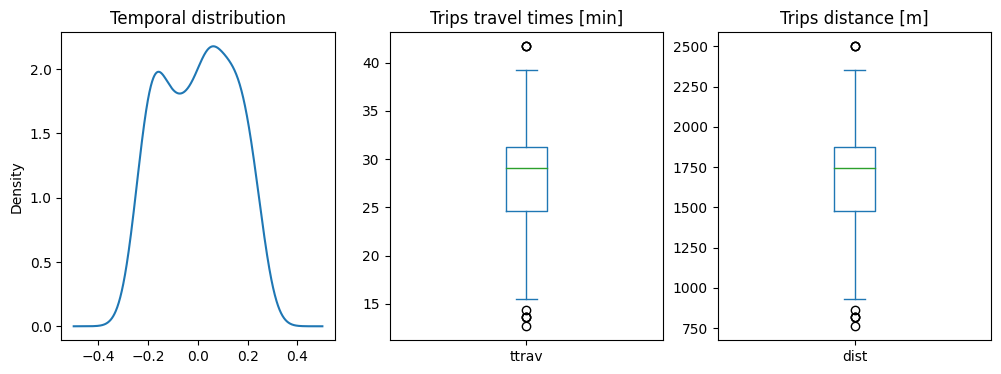

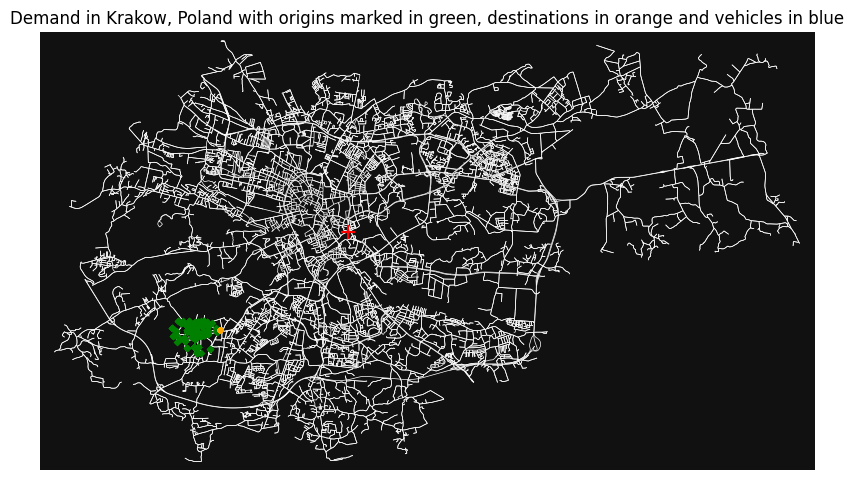

In [20]:
ExMAS.utils.plot_demand(inData, params)